# Calculating Weight Updates

April 26, 2022

Can we see if RFLO leads to linear weight updates? Do weight updates align well? Under what conditions does this hold?

* learning `w_rec` alone
* learning `w_rec` and `w_fb`
* learning `w_rec` and `w_out`
* different initializations
* different coupling strengths
* duration of input signal

And similarly, can we estimate this for BPTT and REINFORCE?



In order to do this, we need to be able to 'store' or 'probe' the weight changes

What we essentially see is that for a single task, consecutive weight updates go in similar directions (i.e. are aligned) for RFLO. This is pretty neat! It means that we can say updates over the course of training are roughly linear!

For REINFORCE, each update is not correlated with the last, however the alignment of average update with w_out increases over training. So...it does follow the gradient in a very direct way!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories

In [3]:
# define f and df

def f_linear(x):
    return x

def df_linear(x):
    return 1

### Train RNN on four targets using RFLO

In [4]:
trial_duration = 20
n_in=4
frac_on = 1

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

## 1. Training `w_rec` only using RFLO, with velocity transformation



In [5]:
0.1/0.05

2.0

11it [00:00, 108.59it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.0
tau_rec: 5
dt: 1
eta_in: 0.1
eta_rec: 0.01
eta_out: 0.01
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: True
eta_fb: 0.05
sig_fb: 0.0
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb44d7c0b88>


52it [00:00, 210.17it/s]


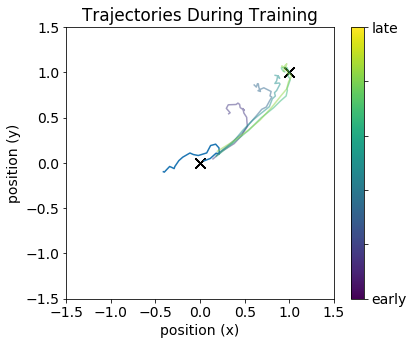

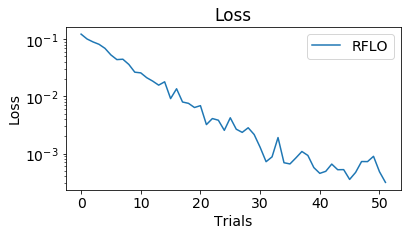

In [68]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,dt = 1, # note that tau_rec and dt are anticorrelated
               eta_in=0.1,eta_rec=0.01,eta_out=0.01,eta_fb=0.05,
               sig_in=0.0,sig_rec=1.0*np.sqrt(0.01),sig_out=0.0,sig_fb=0.0,
               g_rec=1.5,
               velocity_transform=False,
               driving_feedback=True,
               rng=np.random.RandomState(27))

params.print_params()

# Initialize RNN
net = RNN(params)#,f=f_linear,df=df_linear)

# initialize simulation
sim = Simulation(net)

rflo = RFLO(net,apply_to=['w_rec','w_out'],online=False)
#bptt = BPTT(net,apply_to=['w_rec'])

sim.run_session(n_trials=52, tasks=[task1], learn_alg=[rflo], probe_types=['pos','h','w_rec','loss','err'], plot=True, plot_freq=10) # probes can store weights at each timestep


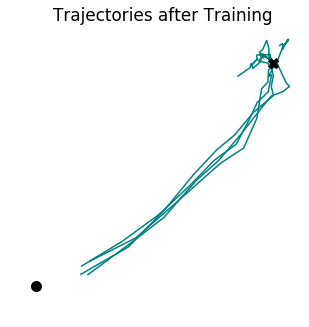

In [69]:
fig = plot_trained_trajectories(sim=sim, tasks=[task1])


number of trials:  52


Text(0.5, 1.0, 'RFLO, 1 Target, Train W_rec and W_out')

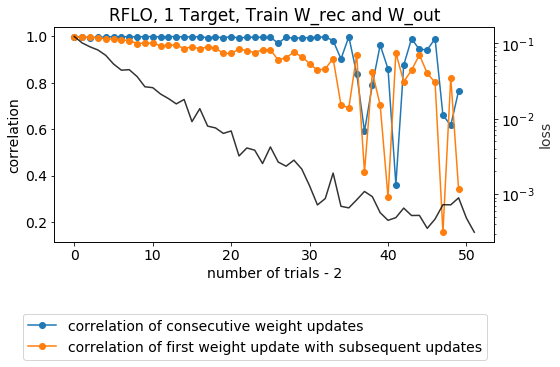

In [70]:
""" Analyze weight updates"""

fig,ax = plt.subplots(1,1,figsize=(8,4))



W = sim.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0] # previous change/update
    deltaW2 = W[n+2][0] - W[n+1][0] # subsequent change/update

    corrs.append(np.corrcoef(deltaW1.ravel(),deltaW2.ravel())[0,1])
    
ax.plot(corrs,'o-',label='correlation of consecutive weight updates')
#plt.ylim([0,1.2])

""" correlation with later updates"""
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[1][0] - W[0][0]
    deltaW2 = W[n+2][0] - W[n+1][0]

    corrs.append(np.corrcoef(deltaW1.ravel(),deltaW2.ravel())[0,1])
    
ax.plot(corrs,'o-',label='correlation of first weight update with subsequent updates')
#ax.set_ylim(bottom=0)
ax.set_xlabel('number of trials - 2')
ax.set_ylabel('correlation')

#ax1.set_ylim(top=0.2)

ax1 = ax.twinx()
loss = np.mean(np.asarray(sim.session_probes['loss']),axis=1)
#std = np.std(np.asarray(sim.session_probes['loss']),axis=1)
ax1.plot(loss,color='k',alpha=0.8)
#ax1.fill_between(np.arange(len(loss)),loss-std,loss+std,alpha=0.2)
ax1.set_ylabel('loss',color='k',alpha=0.8)
ax1.set_yscale('log')
#ax1.set_ylim(top=np.max(loss))
plt.tight_layout()
ax.legend(bbox_to_anchor=(1,-0.3))

ax.set_title('RFLO, 1 Target, Train W_rec and W_out')



What a neat result! If `w_out` is fixed, updates follow a smooth path?!?!?!?! If `w_out` is _not_ fixed, this no longer is the case

number of trials:  52


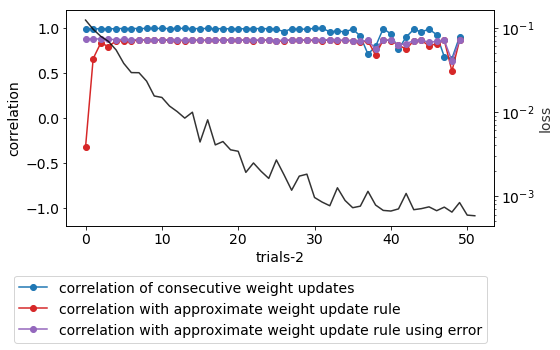

In [39]:
""" Analyze weight updates"""
fig,ax=plt.subplots(1,1,figsize=(8,4))
W = sim.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0]
    deltaW2 = W[n+2][0] - W[n+1][0]

    corrs.append(np.corrcoef(deltaW1.ravel(),deltaW2.ravel())[0,1])
    
plt.plot(corrs,'o-',label='correlation of consecutive weight updates')
plt.ylim([0,1.2])

""" correlation with internal model M Using Position """
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0]
    pos = sim.session_probes['pos'][n].squeeze() # positions at trial n
    activity = sim.session_probes['h'][n].squeeze() # activity at trial n
    deltaA = np.outer(net.w_m @ np.sum(pos,axis=0), np.sum(activity,axis=0))
    
    corrs.append(np.corrcoef(deltaW1.ravel(),deltaA.ravel())[0,1])

plt.plot(corrs,'o-',label='correlation with approximate weight update rule using position',color='C3')

""" correlation with internal model M Using Error """
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0]
    error = sim.session_probes['err'][n].squeeze() # positions at trial n
    activity = sim.session_probes['h'][n].squeeze() # activity at trial n
    deltaA = np.outer(net.w_m @ np.sum(error,axis=0), np.sum(activity,axis=0))
    
    corrs.append(np.corrcoef(deltaW1.ravel(),deltaA.ravel())[0,1])

plt.plot(corrs,'o-',label='correlation with approximate weight update rule using error',color='C4')


plt.ylim([-1.2,1.2])
plt.xlabel('trials-2')
plt.ylabel('correlation')

ax1 = ax.twinx()
loss = np.mean(np.asarray(sim.session_probes['loss']),axis=1)
ax1.plot(loss,color='k',alpha=0.8)
ax1.set_ylabel('loss',color='k',alpha=0.8)
ax1.set_yscale('log')
plt.tight_layout()
ax.legend(bbox_to_anchor=(1.,-0.2))
plt.show()

In [35]:
error

array([], dtype=float64)

number of trials:  52
n_samples,n_features:  (51, 2500)
C:  (10, 2500)


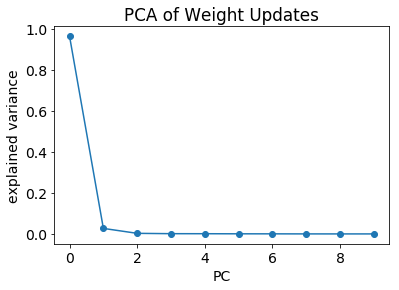

In [10]:
""" PCA on the weight updates """

# concatenate data
W = sim.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
deltaW = []
deltaW.append((W[1][0] - W[0][0]).ravel())
for n in np.arange(1,n_trials-1):
    deltaW = np.vstack((deltaW,(W[n+1][0] - W[n][0]).ravel()))
    
print('n_samples,n_features: ',deltaW.shape)

pca = PCA(n_components=10)
pca.fit(deltaW)
C = pca.components_

print('C: ',pca.components_.shape)
# #plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.title('PCA of Weight Updates')
plt.show()

In [123]:
W[n+1].shape

(20, 50, 50)

# REINFORCE

10it [00:00, 97.47it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.0
tau_rec: 5
dt: 1
eta_in: 0.1
eta_rec: 0.5
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: True
eta_fb: 0.1
sig_fb: 0.0
feedback_signal: position
velocity_transform: False
tau_vel: None
dt_vel: None
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fb4506aa828>


500it [00:01, 332.13it/s]


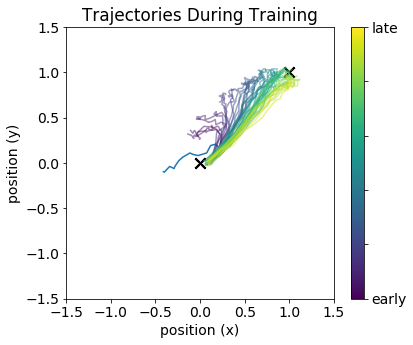

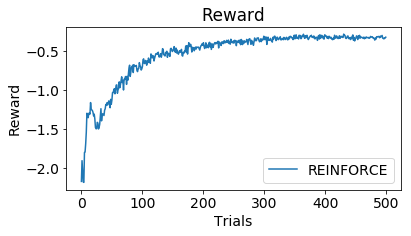

In [40]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=5,dt = 1, # note that tau_rec and dt are anticorrelated
               eta_in=0.1,eta_rec=0.5,eta_out=0.1,eta_fb=0.1,
               sig_in=0.0,sig_rec=1.0*np.sqrt(0.01),sig_out=0.0,sig_fb=0.0,
               g_rec=1.5,
               velocity_transform=False,
               driving_feedback=True,
               rng=np.random.RandomState(27))

params.print_params()

# Initialize RNN
net = RNN(params)#,f=f_linear,df=df_linear)

# initialize simulation
sim = Simulation(net)

#rflo = RFLO(net,apply_to=['w_rec','w_fb'],online=False)
#bptt = BPTT(net,apply_to=['w_rec'])
reinforce = REINFORCE(net,apply_to=['w_rec'],online=False,tau_reward=5)

sim.run_session(n_trials=500, tasks=[task1], learn_alg=[reinforce], probe_types=['pos','h','w_rec','reward','err'], plot=True, plot_freq=10) # probes can store weights at each timestep


number of trials:  500


Text(0.5, 1.0, 'REINFORCE, 1 Target, Train W_rec')

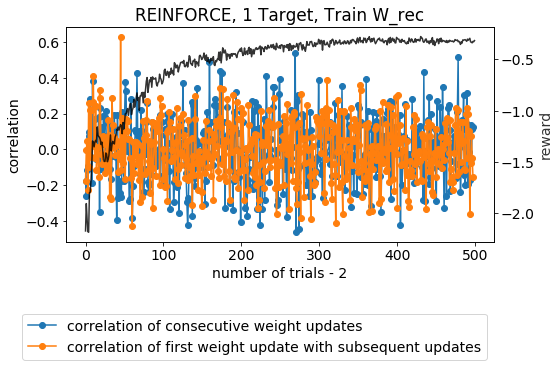

In [41]:
""" Analyze weight updates"""

fig,ax = plt.subplots(1,1,figsize=(8,4))



W = sim.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0] # previous change/update
    deltaW2 = W[n+2][0] - W[n+1][0] # subsequent change/update

    corrs.append(np.corrcoef(deltaW1.ravel(),deltaW2.ravel())[0,1])
    
ax.plot(corrs,'o-',label='correlation of consecutive weight updates')
#plt.ylim([0,1.2])

""" correlation with later updates"""
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[1][0] - W[0][0]
    deltaW2 = W[n+2][0] - W[n+1][0]

    corrs.append(np.corrcoef(deltaW1.ravel(),deltaW2.ravel())[0,1])
    
ax.plot(corrs,'o-',label='correlation of first weight update with subsequent updates')
#ax.set_ylim(bottom=0)
ax.set_xlabel('number of trials - 2')
ax.set_ylabel('correlation')

#ax1.set_ylim(top=0.2)

ax1 = ax.twinx()
reward = np.mean(np.asarray(sim.session_probes['reward']),axis=1)
#std = np.std(np.asarray(sim.session_probes['loss']),axis=1)
ax1.plot(reward,color='k',alpha=0.8)
#ax1.fill_between(np.arange(len(loss)),loss-std,loss+std,alpha=0.2)
ax1.set_ylabel('reward',color='k',alpha=0.8)
# ax1.set_yscale('log')
#ax1.set_ylim(top=np.max(loss))
plt.tight_layout()
ax.legend(bbox_to_anchor=(1,-0.3))

ax.set_title('REINFORCE, 1 Target, Train W_rec')



number of trials:  500


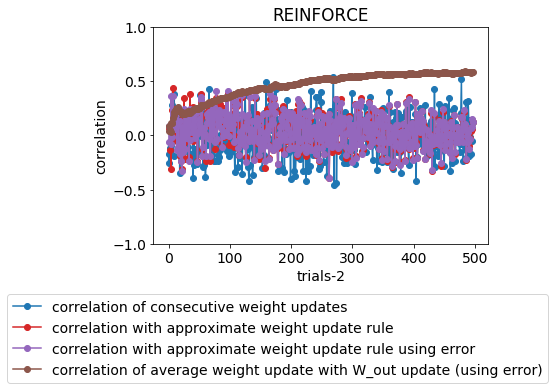

In [51]:
""" Analyze weight updates"""

W = sim.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0]
    deltaW2 = W[n+2][0] - W[n+1][0]

    corrs.append(np.corrcoef(deltaW1.ravel(),deltaW2.ravel())[0,1])
    
plt.plot(corrs,'o-',label='correlation of consecutive weight updates')
plt.ylim([0,1.2])

""" correlation with W_out.T using position """
corrs = []
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0]
    pos = sim.session_probes['pos'][n].squeeze() # positions at trial n
    activity = sim.session_probes['h'][n].squeeze() # activity at trial n
    deltaA = np.outer(net.w_out.T @ np.sum(pos,axis=0), np.sum(activity,axis=0))
    
    corrs.append(np.corrcoef(deltaW1.ravel(),deltaA.ravel())[0,1])

plt.plot(corrs,'o-',label='correlation with approximate weight update rule',color='C3')


""" correlation with W_out.T using average error """
av_error = np.mean(np.asarray(sim.session_probes['err'][0:100]),axis=0).squeeze() # positions at trial n

corrs = []
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0]
    activity = sim.session_probes['h'][n].squeeze() # activity at trial n
    deltaA = np.outer(net.w_out.T @ np.sum(av_error,axis=0), np.sum(activity,axis=0))
    
    corrs.append(np.corrcoef(deltaW1.ravel(),deltaA.ravel())[0,1])

plt.plot(corrs,'o-',label='correlation with approximate weight update rule using error',color='C4')


""" correlation with W_out.T using average error """
av_error = np.mean(np.asarray(sim.session_probes['err'][0:100]),axis=0).squeeze() # positions at trial n

delta_W_all = []
corrs=[]
for n in range(n_trials-2):
    deltaW1 = W[n+1][0] - W[n][0]
    delta_W_all.append(deltaW1)
    activity = sim.session_probes['h'][n].squeeze() # activity at trial n
    deltaA = np.outer(net.w_out.T @ np.sum(av_error,axis=0), np.sum(activity,axis=0))
    
    delta_W_av = np.mean(np.asarray(delta_W_all),axis=0)
    corrs.append(np.corrcoef(delta_W_av.ravel(),deltaA.ravel())[0,1])

plt.plot(corrs,'o-',label='correlation of average weight update with W_out update (using error)',color='C5')



plt.ylim([-1.0,1.0])
plt.ylabel('correlation')
plt.title('REINFORCE')
plt.xlabel('trials-2')
plt.legend(bbox_to_anchor=(1.2,-0.2))

number of trials:  500
n_samples,n_features:  (499, 2500)
C:  (10, 2500)


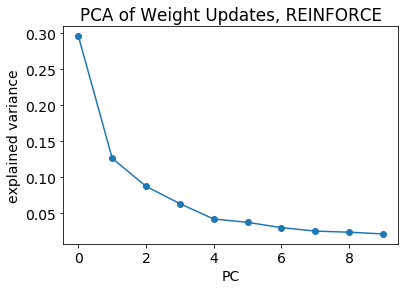

In [28]:
""" PCA on the weight updates """

# concatenate data
W = sim.session_probes['w_rec']
print('number of trials: ',len(W))

n_trials = len(W)

""" correlation with subsequent update"""
deltaW = []
deltaW.append((W[1][0] - W[0][0]).ravel())
for n in np.arange(1,n_trials-1):
    deltaW = np.vstack((deltaW,(W[n+1][0] - W[n][0]).ravel()))
    
print('n_samples,n_features: ',deltaW.shape)

pca = PCA(n_components=10)
pca.fit(deltaW)
C = pca.components_

print('C: ',pca.components_.shape)
# #plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.title('PCA of Weight Updates, REINFORCE')
plt.show()

100it [00:00, 346.29it/s]


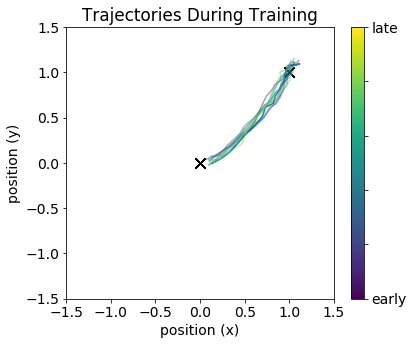

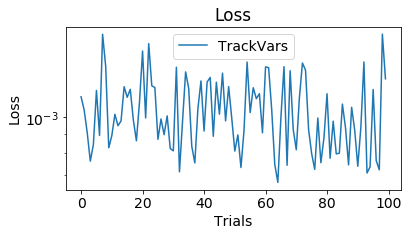

In [21]:
trackvars = TrackVars(net,apply_to=[])

sim.run_session(n_trials=100, tasks=[task1], learn_alg=[trackvars], probe_types=['h','pos','w_rec'], plot=True, plot_freq=10)

(20, 2, 1)